In [1]:
from __future__ import division
import numpy as np
import math

In [ ]:
from mlfromscratch.unsupervised_learning import PCA
from mlfromscratch.supervised_learning import ClassificationTree
from mlfromscratch.utils.misc import bar_widgets
from mlfromscratch.utils import Plot

### entropy  
*  info (Chinese) https://www.cnblogs.com/ShaneZhang/p/3970176.html
* https://medium.com/udacity/shannon-entropy-information-gain-and-picking-balls-from-buckets-5810d35d54b4

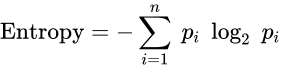     

H(x) = E[I(xi)] = E[ log(2,1/p(xi)) ] = -∑p(xi)log(2,p(xi)) (i=1,2,..n)  
e.g. 32 instance: -(p1*log(2,p1) + p2 * log(2,p2) +　．．．　+p32 *log(2,p32))  


In [11]:
math.log(2,2)

1.0

In [32]:
%%timeit
math.log(100,10)

The slowest run took 17.85 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 281 ns per loop


In [33]:
%%timeit
math.log(100) / math.log(10)

The slowest run took 14.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 401 ns per loop


In [36]:
def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    #log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        #entropy += -p * log2(p)
        entropy += -p * math.log(p,2)
        
    return entropy

In [37]:
calculate_entropy(np.array([1,1,1,2,5,3,7,7,5,12]))

2.4464393446710155

In [38]:
from sklearn import datasets
X, y = datasets.load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

#### Divide dataset based on if sample value on feature index is larger than the given threshold

In [3]:
def divide_on_feature(X, feature_i, threshold):
    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    
    split_func = None
    
    if isinstance(threshold, int) or isinstance(threshold, float):
        
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])

In [60]:
# first record
X[:1]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01]])

* e.g. for the feature index 2 (third column), split dataset to a -- feature value >=100, b -- feature value <100

In [61]:
a, b = divide_on_feature(X, 2, 100)
a.shape, b.shape

((165, 30), (404, 30))

### train test split

In [62]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [63]:
def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

#### Return random subsets (with replacements) of the data

In [4]:
def get_random_subsets(X, y, n_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples      # 100% with replacements

    for _ in range(n_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets

### normalize array
http://www.fundza.com/vectors/normalize/

o normalize a vector in math means to divide each of its elements  
to some value V so that the length/norm of the resulting vector is 1.  
Turns out the needed V is equal the length (the length of the vector).  

Say you have this array.  

[-3, +4]  

Its length (in Euclid metric) is: V = sqrt((-3)^2 + (+4)^2) = 5  

So its corresponding normalized vector is:  

[-3/5, +4/5]  

Its length is now: sqrt ( (-3/5)^2 + (+4/5)^2 ) which is 1.  

In [67]:
np.expand_dims?

In [74]:
print np.array([[1,2,3],[4,5,6]]).shape
np.array([[1,2,3],[4,5,6]])

(2, 3)


array([[1, 2, 3],
       [4, 5, 6]])

In [73]:
print np.expand_dims(np.array([[1,2,3],[4,5,6]]), -1).shape
np.expand_dims(np.array([[1,2,3],[4,5,6]]), -1)

(2, 3, 1)


array([[[1],
        [2],
        [3]],

       [[4],
        [5],
        [6]]])

In [5]:
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


####  X_std = (X - X.mean(axis=0)) / X.std(axis=0)

In [76]:
def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

#### accuracy_score

In [77]:
def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

In [78]:
def acc_sc(y, y_pd):
    n=len(y)
    assert n==len(y_pd)
    true = sum(map(lambda x,y: x==y, y, y_pd))
    return float(true)/n

### random forest

* bagging and boosting  
https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

In [ ]:
class RandomForest():
    """Random Forest classifier. Uses a collection of classification trees that
    trains on random subsets of the data using a random subsets of the features.
    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    max_features: int
        The maximum number of features that the classification trees are allowed to
        use.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_gain: float
        The minimum impurity required to split the tree further. 
    max_depth: int
        The maximum depth of a tree.
    """
    def __init__(self, n_estimators=100, max_features=None, min_samples_split=2,
                 min_gain=0, max_depth=float("inf")):
        self.n_estimators = n_estimators    # Number of trees
        self.max_features = max_features    # Maxmimum number of features per tree
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain            # Minimum information gain req. to continue
        self.max_depth = max_depth          # Maximum depth for tree
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        # Initialize decision trees
        self.trees = []
        for _ in range(n_estimators):
            self.trees.append(
                ClassificationTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_gain,
                    max_depth=self.max_depth))

    def fit(self, X, y):
        n_features = np.shape(X)[1]
        # If max_features have not been defined => select it as
        # sqrt(n_features)
        if not self.max_features:
            self.max_features = int(math.sqrt(n_features))

        # Choose one random subset of the data for each tree
        subsets = get_random_subsets(X, y, self.n_estimators)

        for i in self.progressbar(range(self.n_estimators)):
            X_subset, y_subset = subsets[i]
            # Feature bagging (select random subsets of the features)
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            # Save the indices of the features for prediction
            self.trees[i].feature_indices = idx
            # Choose the features corresponding to the indices
            X_subset = X_subset[:, idx]
            # Fit the tree to the data
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
        # Let each tree make a prediction on the data
        for i, tree in enumerate(self.trees):
            # Indices of the features that the tree has trained on
            idx = tree.feature_indices
            # Make a prediction based on those features
            prediction = tree.predict(X[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        # For each sample
        for sample_predictions in y_preds:
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        return y_pred